In [1]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials  
using Roots
using Plots
using StatsFuns

                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary  
# include("../model_MC.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  

compute_higher_derivs

In [2]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [3]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 2

# training
x1 = [0., .5, .8, 1., 1.6, 2.]
x2 = [0., .5, .8, 1., 2.]
x3 = [0., .8, 1., 1.6, 2.]
x4 = [0., 1., 1.6, 2.]

# testing
x01 = .25
x02 = 1.2
x03 = .5
x04 = .6

# underlying 1d function
test_fun1(x) = sin(x) + 1.1
test_fun2(x) = sin(15*x) + (x^2+1) 
test_fun3(x) = log(x^2+1) + (x^3+x+1)/(exp(x)) 

test_fun3 (generic function with 1 method)

# Summary
**Settings parameters**: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data
test_fun: underlying function

**Tests**:
1. p=1 or p=2, x=x1, x0=x01, test_fun=test_fun1 \
    narrow pdf, some quantile comp hard ==> bracketing interval $[0,5]$ works well!
2. p=1, x2, x02, test_fun2 \
    pdf very large near 0, so 2.5% quantile estimation gives negative estimate, which is not a good guess and also indicates that 2.5% quantile is extremely small. 
3. p=1, x3, x03, test_fun3 \
    narrow pdf, median hard ==> bracketing interval $[0,5]$ works well! \
    cdf(0) = 0.02898, 2.5% quantile doesn't exist
4. p=1, x4, x04, test_fun1 \
    two-peak pdf, can do mode, some quantile, but two-peak makes computation of CI (equal and narrow) super hard.
    
**Conclusion**:
1. Narrow pdf is the hardest case. Even if quant0 provides relatively good initial guess, find_zero easily goes to negative region, where CDF is not defined. \
Solution: bracketing interval works better than initial guess in root-finding
2. cdf(0) > 2.5% makes 2.5% quantile doesn't exist          
3. Weird shape: large pdf near 0 and two-peak pdf should be carefully treated. 
 

In [4]:
p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x3 # choose training data 
x0 = x03 # choose testing data
test_fun = test_fun1 # choose underlying function

x = reshape(x, size(x, 1), 1)
x0 = reshape([x0], 1, 1) 
Fx = covariate_fun(x, p)
y = reshape(test_fun.(x), size(x, 1))
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = reshape(test_fun.(x0), 1)./ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")

Prediction at x0 = [0.5]
Covariates at x0: [1.0]
Should expect peak near [0.752260142876725]


In [5]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 100]
rangeλ = [0.5 5]

btg1 = btg(trainingData1, rangeθ, rangeλ; quadtype = ["MonteCarlo", "MonteCarlo"])
weightTensorGrid = weight_comp(btg1)
pdf, cdf, dpdf, quantInfo = solve(btg1);

In [6]:
btg2 = btg(trainingData1, rangeθ, rangeλ)
weightTensorGrid2 = weight_comp(btg2)
pdf2, cdf2, dpdf2, quantInfo2 = solve(btg2);

In [7]:
btg3 = btg(trainingData1, rangeθ, rangeλ; quadtype = ["MonteCarlo", "Gaussian"])
weightTensorGrid3 = weight_comp(btg3)
pdf3, cdf3, dpdf3, quantInfo3 = solve(btg3);

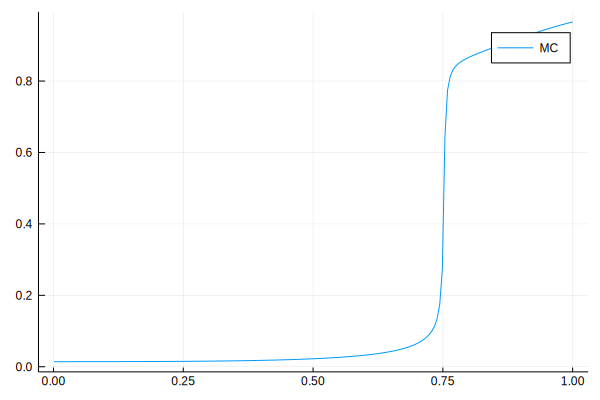

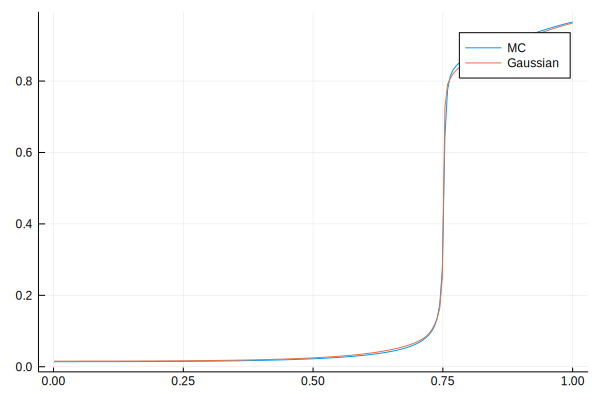

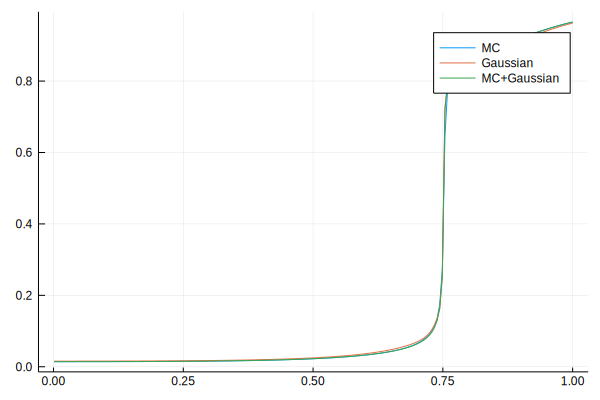

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.014277467213829765, 0.014280689264920175, 0.014284154043663944, 0.014287979021639089, 0.014292186060157022, 0.014296788268451044, 0.014301797754986093, 0.014307227156796321, 0.014313089998148468, 0.014319400759271007  …  0.9475110411989168, 0.9497218260593658, 0.9518834570182375, 0.9539932438002061, 0.9560487019695587, 0.9580475826357324, 0.9599878980294693, 0.9618679424084893, 0.9636863078847042, 0.9654418949189807])

In [8]:
# Plot to see the shape of pdf and cdf
dpdf_fixed = y0 -> dpdf(x0, Fx0, y0) 
pdf_fixed = y0 -> pdf(x0, Fx0, y0)
cdf_fixed = y0 -> cdf(x0, Fx0, y0)
dpdf_fixed2 = y0 -> dpdf2(x0, Fx0, y0) 
pdf_fixed2 = y0 -> pdf2(x0, Fx0, y0)
cdf_fixed2 = y0 -> cdf2(x0, Fx0, y0)
dpdf_fixed3 = y0 -> dpdf3(x0, Fx0, y0) 
pdf_fixed3 = y0 -> pdf3(x0, Fx0, y0)
cdf_fixed3 = y0 -> cdf3(x0, Fx0, y0)
a = 1e-3; b = 1.
plt(cdf_fixed, a, b, 200, label = "MC")
plt!(cdf_fixed2, a, b, 200, label = "Gaussian")
plt!(cdf_fixed3, a, b, 200, label = "MC+Gaussian")

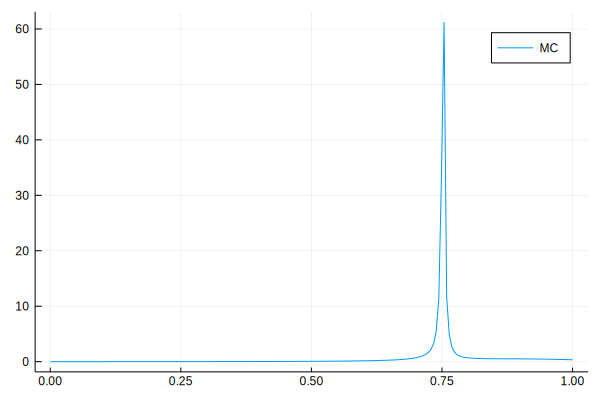

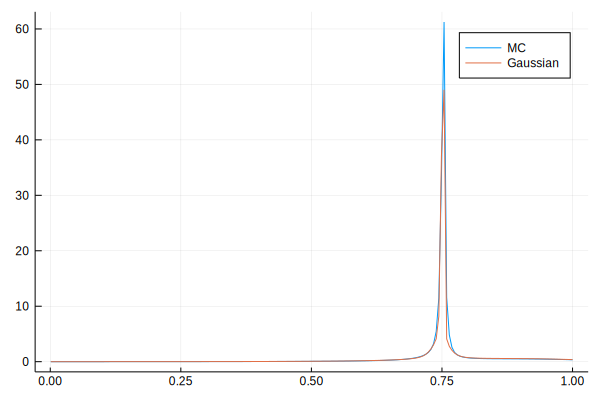

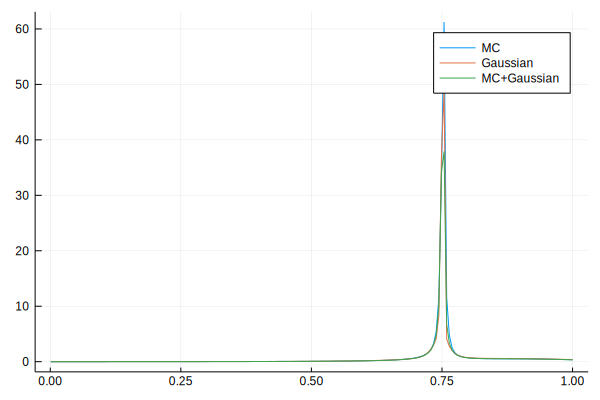

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.0006692666107628719, 0.0006574475959269879, 0.0007249901479695222, 0.0007994997528218352, 0.0008769963574642523, 0.0009569143053266109, 0.0010392757489869602, 0.001124238087753701, 0.001211989309969627, 0.001302720097605058  …  0.44509470084697766, 0.4355832782725937, 0.42551760635827557, 0.41493548667505914, 0.40388100793197085, 0.39240378478525295, 0.3805580773836656, 0.368401815554978, 0.3559955565118233, 0.34340140824678733])

In [9]:
plt(pdf_fixed, a, b, 200, label = "MC")
plt!(pdf_fixed2, a, b, 200, label = "Gaussian")
plt!(pdf_fixed3, a, b, 200, label = "MC+Gaussian")

# Quantile computation

In [10]:
include("test_quantile.jl")
include("../statistics.jl")

credible_interval (generic function with 3 methods)

In [11]:
# preprocess output from solve(btg)
pdf_fixed, cdf_fixed, dpdf_fixed, quant0, support = pre_process(x0, Fx0, pdf, cdf, dpdf, quantInfo[1]);
println("MC: Estimated support of pdf: $support")
pdf_fixed2, cdf_fixed2, dpdf_fixed2, quant02, support2 = pre_process(x0, Fx0, pdf2, cdf2, dpdf2, quantInfo2[1]);
println("Gaussian: Estimated support of pdf: $support2")
pdf_fixed3, cdf_fixed3, dpdf_fixed3, quant03, support3 = pre_process(x0, Fx0, pdf3, cdf3, dpdf3, quantInfo3[1]);
println("MonteCarlo + Gaussian: Estimated support of pdf: $support3")

MC: Estimated support of pdf: [0.001, 5.0]
Gaussian: Estimated support of pdf: [0.001, 5.0]
MonteCarlo + Gaussian: Estimated support of pdf: [0.001, 5.0]


In [12]:
DistributionInfo = summary_comp(pdf_fixed, cdf_fixed, dpdf_fixed, quant0, support; px = .8)

(quantile = (level = 0.8, value = 0.7619031639429357, error = 5.551115123125783e-16), median = (value = 0.7523891019716341, error = 1.3766765505351941e-14), mode = 0.7524107334122344, CIequal = (equal = [0.535289935517153, 1.0316033625014813], error = 1.1686558153949016e-16), CInarrow = nothing)

In [13]:
DistributionInfo2 = summary_comp(pdf_fixed2, cdf_fixed2, dpdf_fixed2, quant02, support2; px = .8)

(quantile = (level = 0.8, value = 0.7617275300962804, error = 2.7755575615628914e-16), median = (value = 0.7519287222738993, error = 1.687538997430238e-14), mode = 0.7521214918859883, CIequal = (equal = [0.5013929261758144, 1.0392138895227303], error = 0.0), CInarrow = nothing)

In [14]:
DistributionInfo3 = summary_comp(pdf_fixed3, cdf_fixed3, dpdf_fixed3, quant03, support3; px = .8)

(quantile = (level = 0.8, value = 0.7596685689158583, error = 0.0), median = (value = 0.7521475736481191, error = 5.10702591327572e-14), mode = 0.7523300689306791, CIequal = (equal = [0.5321737371516958, 1.0314965226674864], error = 0.0), CInarrow = nothing)